In [7]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('..')
from wombats.anomalies.increasing import GWN
from wombats.detectors.feature_based import *
from wombats.detectors.pca_based import *
from wombats.detectors.gaussian_distribution_based import *
from wombats.detectors.ml_based import *
from wombats.datasets.data_utils import load_data_test, load_data_training

## Load Data

In [8]:
ninst = 1_000
data_type = 'bridge'

if data_type == 'ecg':
    n = 256
    SNRdB = 40
    channels = ['z']
elif data_type == 'bridge':
    channels = ['x']
    n = 100
    SNRdB = None

Xok_train, _ = load_data_training(channels, n, data_type)
Xok_train = Xok_train[:ninst, :, -1]
Xok_test = load_data_test(channels, n, data_type)[:ninst, :, -1]
xok_test = Xok_test[0]

## Setup

In [9]:
def dim_princ_sub(Xok, SNRdB=None):
    N = Xok.shape[-2]
    n = Xok.shape[-1]
    Sok = 1/(N-1) * Xok.T @ Xok
    eigvals, _ = np.linalg.eigh(Sok)
    lok = eigvals[::-1]

    # Infer the dimension of the principal subspace (PS) k
    singvalues = np.sqrt(lok)
    if SNRdB is None:
        threshold = 2.858 * np.median(singvalues)
    else:
        sigma = 10**(-SNRdB/20)
        threshold = 4/np.sqrt(3) * sigma * np.sqrt(n)

    dim_princ_sub = np.sum(singvalues > threshold)
    if dim_princ_sub%2:
        dim_princ_sub = dim_princ_sub+1
    return dim_princ_sub

In [10]:
metric = 'P_D' #P_D, AUC
delta=0.1
k = dim_princ_sub(Xok_test, SNRdB)
kernel = 'rbf'
nu = 0.01
h = 5
l = 250
p = 16
detectors_labels = [f'SPE_{k}', f'T2_{k}', f'AR_{p}', f'OCSVM_{kernel}_{nu}', f'LOF_{h}',f'IF_{l}', 'MD', 'energy', 'TV', 'ZC', 'pk-pk']
detectors = [SPE(k), T2(k), AR(p), OCSVM(kernel, nu), LOF(h), IF(l), MD(), energy(), TV(), ZC(), pk_pk()]
detectors_dict = dict(zip(detectors_labels, detectors))

In [11]:
gwn = GWN(delta)
gwn.fit(Xok_test)
Xgwn_gwn = gwn.distort(Xok_test)
X_test = np.concatenate([Xok_test, Xgwn_gwn])

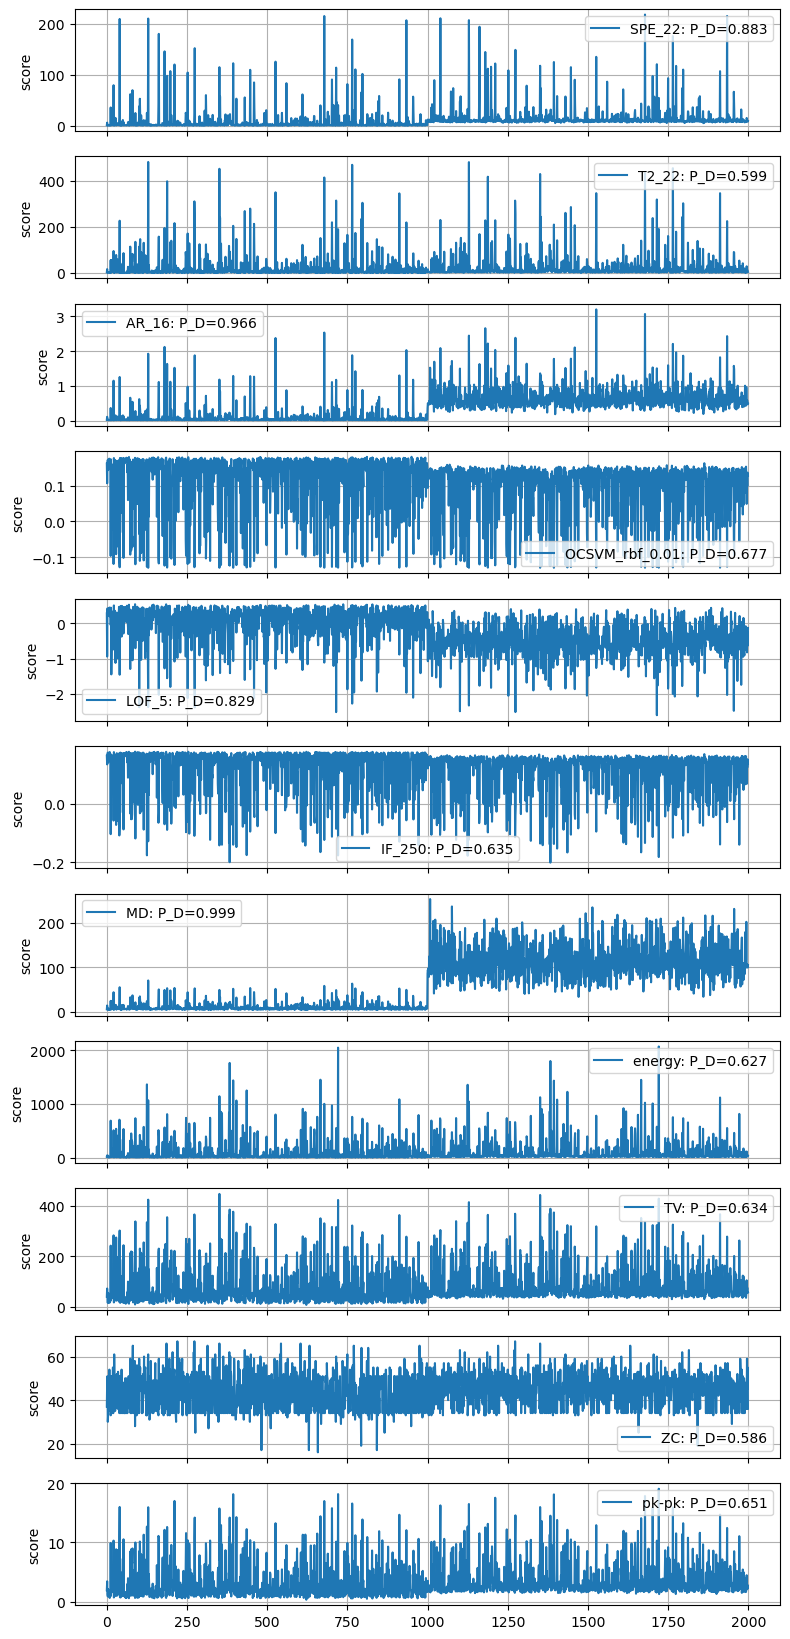

In [12]:
fig, ax = plt.subplots(len(detectors_dict.items()), sharex=True,
                       figsize=(8, 1.5*(len(detectors_dict.items()))))
for name, detector, ax_ in zip(detectors_dict.keys(), detectors_dict.values(), ax):
    scores = detector.fit(Xok_train).score(X_test)
    metric_value = detector.test(X_test, metric)
    ax_.plot(scores, label=f'{name}: {metric}={np.round(metric_value, 3)}')
    ax_.legend()
    ax_.grid()
    ax_.set(ylabel='score')
fig.tight_layout()